In [72]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from textstat.textstat import textstat
from gensim.corpora import wikicorpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

In [73]:
file = '../data/enwiki.observations.text_wp10.30k.tsv'
raw_data = pd.read_csv(file, sep='\t', header=None)

In [74]:
data = pd.DataFrame(data=list(raw_data[0].apply(literal_eval)))
data = data[data['text'] != ""]
data = data[data['text'].str.contains("#redirect") == False]
data = data[data['text'].str.contains("may refer to:\n\n*") == False]
data = data[data['text'].str.contains("can refer to:\n") == False]
data = data[data['text'].str.contains("could refer to:\n") == False]
data = data[data['text'].str.contains("#REDIRECT") == False]
data = data[data['text'].str.contains("== Matches ==\n:") == False]
data = data[data['text'].str.contains("{{underconstruction") == False]

In [75]:
data1000 = data[:2000].copy()

In [76]:
classes = {"stub": 0, "start": 1, "c": 2, "b": 3, "ga": 4, "fa": 5} 
data1000["label"] = data1000['label'].map(classes)
data1000

,label,page_title,project,text,timestamp
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659
1,5,Battle of Warsaw (1920),russia,{{Infobox Military Conflict\n|conflict=Battle ...,20070111175847
2,2,Henry Digby (Royal Navy officer),biography,{{Use British English|date=August 2011}}\n{{Us...,20111205102850
3,2,Ottawa Redblacks,canadian football,{{Use mdy dates|date=May 2013}}\n{{Infobox CFL...,20140513220942
4,2,Qimonda,germany,{{Infobox_Company |\n company_name = Qimond...,20090315202104
5,1,"Ocracoke, North Carolina",project north carolina,{{Infobox Settlement\n|official_name ...,20080911150022
6,2,Erik Wilhelm,biography,{{construction}}\n\n{{Infobox NFL player\n| im...,20141125183748
7,0,Kolibite,bulgaria,{{Infobox settlement \n|official_name =Kolibit...,20120524063028
8,3,Edouard Borovansky,ballet,{{Infobox Person\n| name = Edouard Borovansk...,20110208153146
9,0,Jacek Wiśniewski,poland,{{Football player infobox\n| playername= Jacek...,20090105062145


In [77]:
def clean_wiki_markup(raw_article):
    semi_cleaned_article = wikicorpus.filter_wiki(raw_article)
    cleaned_article = semi_cleaned_article.replace("\n", "").replace("\'", "").replace("()", "").replace("=", "").replace("|alt","").replace("\xa0","")
    return cleaned_article

def find_num_categories(raw_article):
    return raw_article.count("[[Category:")

def find_num_images(raw_article):
    return raw_article.count("[[Image:")

def find_num_ISBN(raw_article):
    return raw_article.count("ISBN")

def find_num_references(raw_article):
    return raw_article.count("</ref>")

def find_article_length(cleaned_article):
    return len(cleaned_article)

def find_num_difficult_words(cleaned_article):
    return textstat.difficult_words(cleaned_article)

def find_dale_chall_readability_score(cleaned_article):
    return textstat.dale_chall_readability_score(cleaned_article)

def find_automated_readability_index(cleaned_article):
    return textstat.automated_readability_index(cleaned_article)

def find_linsear_write_formula(cleaned_article):
    return textstat.linsear_write_formula(cleaned_article)

def find_gunning_fog_index(cleaned_article):
    return textstat.gunning_fog(cleaned_article)

def find_syllable_count(cleaned_article):
    return textstat.syllable_count(cleaned_article)

def find_lexicon_count(cleaned_article):
    return textstat.lexicon_count(cleaned_article, removepunct=True)

def find_sentence_count(cleaned_article):
    return textstat.sentence_count(cleaned_article)

def find_smog_index(cleaned_article):
    return textstat.smog_index(cleaned_article)

def find_num_web_citations(raw_article):
    return raw_article.count("{{cite web")

def find_num_book_citations(raw_article):
    return raw_article.count("{{cite book")

def find_num_news_citations(raw_article):
    return raw_article.count("{{cite news")

def find_num_quotes(raw_article):
    return raw_article.count("quote=")

def find_num_h3_headers(raw_article):
    return raw_article.count("\n===")

def find_num_internal_links(raw_article):
    return (raw_article.count("[[") // 2)

def find_num_h2_headers(raw_article):
    return (raw_article.count("\n==") - find_num_h3_headers(raw_article))

In [78]:
data1000['cleaned_text'] = data1000['text'].apply(clean_wiki_markup)

In [10]:
data1000

,label,page_title,project,text,timestamp,cleaned_text
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659,Burgundy under Louis XIA large sculpture of s...
1,5,Battle of Warsaw (1920),russia,{{Infobox Military Conflict\n|conflict=Battle ...,20070111175847,The Battle of Warsaw (sometimes referred to as...
2,2,Henry Digby (Royal Navy officer),biography,{{Use British English|date=August 2011}}\n{{Us...,20111205102850,Admiral of the Blue Sir Henry Digby GCB (20 Ja...
3,2,Ottawa Redblacks,canadian football,{{Use mdy dates|date=May 2013}}\n{{Infobox CFL...,20140513220942,TD Place StadiumThe Ottawa RedBlacks (stylized...
4,2,Qimonda,germany,{{Infobox_Company |\n company_name = Qimond...,20090315202104,"Qimonda AG , (pronounced ""key-MON-da"") is a m..."
5,1,"Ocracoke, North Carolina",project north carolina,{{Infobox Settlement\n|official_name ...,20080911150022,Ocracoke IslandOcracoke is a census-designated...
6,2,Erik Wilhelm,biography,{{construction}}\n\n{{Infobox NFL player\n| im...,20141125183748,"Erik Bradley Wilhelm (born November 16, 1965 i..."
7,0,Kolibite,bulgaria,{{Infobox settlement \n|official_name =Kolibit...,20120524063028,Kolibite is a village in the municipality of S...
8,3,Edouard Borovansky,ballet,{{Infobox Person\n| name = Edouard Borovansk...,20110208153146,Edouard Borovansky (24 February 1902 – 18 Dece...
9,0,Jacek Wiśniewski,poland,{{Football player infobox\n| playername= Jacek...,20090105062145,"Jacek Wiśniewski (born June 8, 1974 in Gliwice..."


# HashVectorizer

In [79]:
hash_vectorizer = HashingVectorizer(n_features=5000)

### Fit Vectorizer

In [80]:
hash_vectorizer.fit(data1000['cleaned_text'])

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=5000, ngram_range=(1, 1), non_negative=False,
         norm='l2', preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

### Transform Vectorizer

In [81]:
X_transformed = hash_vectorizer.transform(data1000['cleaned_text'])

In [82]:
hash_df = pd.DataFrame(X_transformed.todense())

In [83]:
y = data1000.label.values

# Train/Test Split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(hash_df.values, y, test_size=0.20, random_state=910)

# Random Forest Regressor

In [39]:
rf = RandomForestRegressor(n_estimators=10, random_state=910)

In [40]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=910, verbose=0, warm_start=False)

In [41]:
predictions = rf.predict(X_test)

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

1.0636905555555554

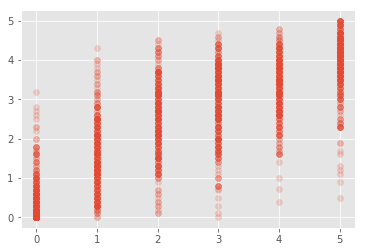

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, alpha=.2)

In [85]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

max_features = 20000
maxlen = 5000
batch_size = 32

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[X_test, y_test])

Train on 1600 samples, validate on 400 samples
Epoch 1/4
1600/1600 [==============================] - 298s 186ms/step - loss: -11.9969 - acc: 0.1594 - val_loss: -23.5549 - val_acc: 0.1750
Epoch 2/4
1600/1600 [==============================] - 285s 178ms/step - loss: -23.8799 - acc: 0.1588 - val_loss: -23.5549 - val_acc: 0.1750
Epoch 3/4
1600/1600 [==============================] - 282s 177ms/step - loss: -23.9516 - acc: 0.1588 - val_loss: -23.5549 - val_acc: 0.1750
Epoch 4/4
1600/1600 [==============================] - 282s 176ms/step - loss: -23.9568 - acc: 0.1588 - val_loss: -23.5549 - val_acc: 0.1750


In [91]:
from pprint import pprint
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [114]:
documents = data1000['cleaned_text'][0]

In [106]:
TaggedDocument(documents,)

TypeError: __new__() missing 1 required positional argument: 'tags'

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [119]:
doc = TaggedDocument(wikicorpus.tokenize(documents), 1)

In [120]:
model = Doc2Vec(doc, vector_size=5, window=2, min_count=1, workers=4)

AttributeError: 'list' object has no attribute 'words'

In [132]:
documents = [TaggedDocument(wikicorpus.tokenize(doc), [i]) for i, doc in enumerate(data1000.cleaned_text[:5])]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [133]:
model

In [134]:
documents

[TaggedDocument(words=['burgundy', 'under', 'louis', 'xia', 'large', 'sculpture', 'of', 'six', 'life', 'sized', 'black', 'cloaked', 'men', 'their', 'faces', 'obscured', 'by', 'their', 'hoods', 'carrying', 'slab', 'upon', 'which', 'lies', 'the', 'supine', 'effigy', 'of', 'knight', 'with', 'hands', 'folded', 'together', 'in', 'prayer', 'his', 'head', 'rests', 'on', 'pillow', 'and', 'his', 'feet', 'on', 'small', 'reclining', 'lion', 'korean', 'tomb', 'mound', 'of', 'king', 'sejong', 'the', 'great', 'türbe', 'of', 'roxelana', 'süleymaniye', 'mosque', 'art', 'is', 'any', 'work', 'of', 'art', 'forming', 'or', 'placed', 'in', 'repository', 'for', 'the', 'remains', 'of', 'the', 'dead', 'tomb', 'is', 'general', 'term', 'for', 'the', 'repository', 'while', 'grave', 'goods', 'are', 'objects', 'other', 'than', 'the', 'primary', 'human', 'remains', 'which', 'have', 'been', 'placed', 'inside', 'such', 'objects', 'may', 'include', 'the', 'personal', 'possessions', 'of', 'the', 'deceased', 'objects', 

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]